
TensorFlow LongFormer NER Baseline - CV 0.633! This notebook is a TensorFlow starter notebook for Kaggle's "Feedback Prize - Evaluating Student Writing" Competition. Currently this notebook uses

backbone LongFormer NER formulation one fold With simple changes, we can convert this notebook into Question Answer formulation and we can try different backbones. Furthermore this notebook is one fold. It trains with 90% data and validates on 10% data. We can convert this notebook to K-fold or train with 100% data for boost in LB.

The transformer model LongFormer is explained here. It is similar to Roberta but can accept inputs as wide as 4096 tokens! In this notebook we feed the transformer with 1024 wide tokens. HuggingFace user AllenAI uploaded pretrained weights for us here. Kaggle discussion about this starter notebook is here

PyTorch BigBird NER Baseline - CV 0.615 I published a PyTorch starter notebook here that uses BigBird backbone. BigBird is another recent SOTA transformer that accomodates tokens as wide as 4096. Unfortunately there are not pretrained BigBird weights for TensorFlow-Keras.

TensorFlow users can benefit from reading the PyTorch starter because the PyTorch encodes the targets differently. It uses the predictionstring column and is_split_into_words=True during tokenization. It also demonstrates how to use a dataloader which is needed if you want to experiment with data augmentation. Because each epoch, we must tokenize the text again after modifying the train text.

Configuration This notebook can either train a new model or load a previously trained model (made from previous notebook version). Furthermore, this notebook can either create new NER tokens or load existing tokens (made from previous notebook version). In this notebook version, we will load model and load NER tokens.

Also this notebook can load huggingface stuff (like tokenizers) from a Kaggle dataset, or download it from internet. (If it downloads from internet, you can then put it in a Kaggle dataset, so next time you can turn internet off).



In [2]:
import os
# DECLARE HOW MANY GPUS YOU WISH TO USE.
# KAGGLE ONLY HAS 1, BUT OFFLINE, YOU CAN USE MORE
# 사용 Gpu 설정
os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu
# VERSION FOR SAVING/LOADING MODEL WEIGHTS
# THIS SHOULD MATCH THE MODEL IN LOAD_MODEL_FROM
VER=14

In [3]:
# IF VARIABLE IS NONE, THEN NOTEBOOK COMPUTES TOKENS
# OTHERWISE NOTEBOOK LOADS TOKENS FROM PATH
LOAD_TOKENS_FROM = '../input/tf-longformer-v12'

In [4]:
# IF VARIABLE IS NONE, THEN NOTEBOOK TRAINS A NEW MODEL
# OTHERWISE IT LOADS YOUR PREVIOUSLY TRAINED MODEL
LOAD_MODEL_FROM = '../input/tflongformerv14'


In [5]:
# IF FOLLOWING IS NONE, THEN NOTEBOOK
# USES INTERNET AND DOWNLOADS HUGGINGFACE
# CONFIG, TOKENIZER, AND MODEL
DOWNLOADED_MODEL_PATH = '../input/tf-longformer-v12'


In [6]:
if DOWNLOADED_MODEL_PATH is None:
    DOWNLOADED_MODEL_PATH = 'model'
MODEL_NAME = 'allenai/longformer-base-4096'

How To Submit TensorFlow Without Internet Many people ask me, how do I submit TensorFlow models without internet? With HuggingFace Transformer, it's easy. Just download the following 3 things (1) model weights, (2) tokenizer files, (3) config file, and upload them to a Kaggle dataset. Below shows code how to get the files from HuggingFace for AllenAI's model longformer-base. But this same code can download any transformer, like for example roberta-base.

In [7]:
if DOWNLOADED_MODEL_PATH == 'model':
    os.mkdir('model')

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.save_pretrained('model')

    config = AutoConfig.from_pretrained(MODEL_NAME)
    config.save_pretrained('model')

    backbone = TFAutoModel.from_pretrained(MODEL_NAME, config=config)
    backbone.save_pretrained('model')


TOKENIZER FILES - merges.txt, tokenizer_config.json, special_tokens_map.json, tokenizer.json, vocab.json CONFIG FILE - config.json MODEL WEIGHT FILE - tf_model.h5 Then just upload all these files to a Kaggle dataset, like what I did https://www.kaggle.com/cdeotte/tf-longformer-v12. Then you load them into your notebook like the notebook you are reading. And we can turn internet off!

In [8]:
import pandas as pd, numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# * 이라고 하면 AutoTokenizer를 여기서 import 한 것인데 명시적으로 드러나지가 않아서 헷갈릴 수가 있다 특히 초심자의 경우
#from transformers import *
from transformers import AutoTokenizer, AutoConfig, TFAutoModel
print('TF version',tf.__version__)

TF version 2.8.0


In [11]:
# USE MULTIPLE GPUS
# 훈련을 여러 gpu로 나누어서 처리하기 위한 텐서플로 api
if os.environ["CUDA_VISIBLE_DEVICES"].count(',') == 0:
    strategy = tf.distribute.get_strategy()
    print('single strategy')
else:
    # 각 gpu에 변수들을 복제 해서 사용한다

    strategy = tf.distribute.MirroredStrategy()
    print('multiple strategy')

single strategy


In [12]:
# 특정 float32 -> float16 으로 변경
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('Mixed precision enabled')

Mixed precision enabled


In [13]:
train = pd.read_csv('../input/feedback-prize-2021/train.csv')
print( train.shape )
train.head()

(144293, 8)


,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


In [14]:
print('The train labels are:')
train.discourse_type.unique()

The train labels are:


array(['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement',
       'Counterclaim', 'Rebuttal'], dtype=object)

The following code converts Kaggle's train dataset into a NER token array that we can use to train a NER transformer. I have made it very clear which targets belong to which class. This allows us to very easily convert this code to Question Answer formulation if we want. Just change the 14 NER arrays to be 14 arrays of start position and end position for each of the 7 classes. (You will need to think creatively what to do if a single text has multiple of one class).


In [15]:
IDS = train.id.unique()
print('There are',len(IDS),'train texts.')

There are 15594 train texts.


Tokenize Train The following code converts Kaggle's train dataset into a NER token array that we can use to train a NER transformer. I have made it very clear which targets belong to which class. This allows us to very easily convert this code to Question Answer formulation if we want. Just change the 14 NER arrays to be 14 arrays of start position and end position for each of the 7 classes. (You will need to think creatively what to do if a single text has multiple of one class).

In [16]:
MAX_LEN = 1024

In [17]:

# THE TOKENS AND ATTENTION ARRAYS
tokenizer = AutoTokenizer.from_pretrained(DOWNLOADED_MODEL_PATH)
train_tokens = np.zeros((len(IDS),MAX_LEN), dtype='int32')
train_attention = np.zeros((len(IDS),MAX_LEN), dtype='int32')


In [18]:
# THE 14 CLASSES FOR NER
lead_b = np.zeros((len(IDS),MAX_LEN))
lead_i = np.zeros((len(IDS),MAX_LEN))

In [19]:
position_b = np.zeros((len(IDS),MAX_LEN))
position_i = np.zeros((len(IDS),MAX_LEN))


In [20]:
evidence_b = np.zeros((len(IDS),MAX_LEN))
evidence_i = np.zeros((len(IDS),MAX_LEN))

In [21]:
claim_b = np.zeros((len(IDS),MAX_LEN))
claim_i = np.zeros((len(IDS),MAX_LEN))
conclusion_b = np.zeros((len(IDS),MAX_LEN))
conclusion_i = np.zeros((len(IDS),MAX_LEN))
counterclaim_b = np.zeros((len(IDS),MAX_LEN))
counterclaim_i = np.zeros((len(IDS),MAX_LEN))
rebuttal_b = np.zeros((len(IDS),MAX_LEN))
rebuttal_i = np.zeros((len(IDS),MAX_LEN))
# HELPER VARIABLES
train_lens = []
targets_b = [lead_b, position_b, evidence_b, claim_b, conclusion_b, counterclaim_b, rebuttal_b]
targets_i = [lead_i, position_i, evidence_i, claim_i, conclusion_i, counterclaim_i, rebuttal_i]
target_map = {'Lead':0, 'Position':1, 'Evidence':2, 'Claim':3, 'Concluding Statement':4,
             'Counterclaim':5, 'Rebuttal':6}


In [22]:
assert( np.sum(train.groupby('id')['discourse_start'].diff()<=0)==0 )
# 클래스별로 모두 15000여개의 text를 할당한 targets_b 에서
# 해당하는 id_num의 offset_index에 1을 할당
# FOR LOOP THROUGH EACH TRAIN TEXT

# 3차원이라 복잡하기는 하다
# 분류별로 offset이 어떤 discourse 에서는 이러한 분류를 사용하였다는 것을 저장한다

# for 문 이 정도의 길이는 항상 함수적인 관점으로 보고 전체를 해석
# 변수와 흐름이 어떻게 되있는 건지
# IDS에서 id_num 에 해당하는 txt 를 tokenizing 한 후 offset 을 구한 뒤


In [23]:
from tqdm import tqdm_notebook

In [24]:
for id_num in tqdm_notebook(range(len(IDS))):
    if LOAD_TOKENS_FROM: break
    # 띄어쓰기, 개행 x -> end=""
    if id_num%100==0: print(id_num,', ',end='')

    # READ TRAIN TEXT, TOKENIZE, AND SAVE IN TOKEN ARRAYS
    n = IDS[id_num]
    name = f'../input/feedback-prize-2021/train/{n}.txt'
    txt = open(name, 'r').read()
    train_lens.append( len(txt.split()))
    tokens = tokenizer.encode_plus(txt, max_length=MAX_LEN, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
    train_tokens[id_num,] = tokens['input_ids']
    train_attention[id_num,] = tokens['attention_mask']

    # FIND TARGETS IN TEXT AND SAVE IN TARGET ARRAYS
    # hugging face offset_mapping 은 분할 토큰의 첫 번째 하위 토큰에 대해서만 학습하는 것
    #https://huggingface.co/transformers/v4.2.2/custom_datasets.html
    #offset은 original token이 split될 때의 sub-token의 (start position, end position)
    offsets = tokens['offset_mapping']
    offset_index = 0
    df = train.loc[train.id==n]
    for index,row in df.iterrows():
        a = row.discourse_start
        b = row.discourse_end
        if offset_index>len(offsets)-1:
            break
        c = offsets[offset_index][0]
        d = offsets[offset_index][1]
        beginning = True
        while b>c:
            if (c>=a)&(b>=d):
                k = target_map[row.discourse_type]
                if beginning:
                    # targets_b 에서 discourse type만큼 id_num을 배치해두었고 따라서 해당 type의 차원에서 id_num의 offset_index에 1을 marking하여서
                    # 같은 문장(id_num)이 여러 개의 분류(k)로 속하게 되는 것을 학습한다 여기서는 offset_index라는 원래 인덱스를 찾으니까 offset_index번째의 문자가 해당 분류로 학습될 것
                    # beginning 에 할당
                    ## offset 에 해당하는 class 를 할당
                    targets_b[k][id_num][offset_index] = 1
                    beginning = False
                else:
                    # 중간에 할당
                    targets_i[k][id_num][offset_index] = 1
            offset_index += 1
            if offset_index>len(offsets)-1:

                break
            c = offsets[offset_index][0]
            d = offsets[offset_index][1]

/var/folders/c6/2j22b1rd02778st12c0mcr3w0000gn/T/ipykernel_70375/1298916380.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for id_num in tqdm_notebook(range(len(IDS))):


  0%|          | 0/15594 [00:00<?, ?it/s]

In [ ]:
# offsets 또한 해당 id 에서 만들어진 offsets 이다 df의 row별로 가진 discourse type 에서의 offset을 저장하는 것
# 구조적으로 offsets 에는 token이 원래 text에서 어디에서 어디부터까지로 input id 가 되었는 지의 인덱스를 가지고 있다
# targets_b 에는 각 클래스별로 모든 discourse 를 할당해놓았으며
# train set에서 같은 id를 가지는 df 를 순회하여 target 을 찾아 target array에 저장을한다
# find targets in text(df) and save in targets arrays

In [ ]:
#end>offset[0] -> 97
#offset[0] >start -> 95
#offsets[21]

In [25]:

if LOAD_TOKENS_FROM is None:
    plt.hist(train_lens, bins=100)
    plt.title('Histogram of Train Word Counts' , size=16)
    plt.xlabel('Train Word Count', size=14)
    plt.show()

In [26]:
if LOAD_TOKENS_FROM is None:
    targets = np.zeros((len(IDS),MAX_LEN,15), dtype='int32')
    for k in range(7):
        targets[:,:,2*k] = targets_b[k]
        targets[:,:,2*k+1] = targets_i[k]
    targets[:,:,14] = 1-np.max(targets,axis=-1)

>

In [27]:
if LOAD_TOKENS_FROM is None:
    np.save(f'targets_{MAX_LEN}', targets)
    np.save(f'tokens_{MAX_LEN}', train_tokens)
    np.save(f'attention_{MAX_LEN}', train_attention)
    print('Saved NER tokens')
else:
    targets = np.load(f'{LOAD_TOKENS_FROM}/targets_{MAX_LEN}.npy')
    train_tokens = np.load(f'{LOAD_TOKENS_FROM}/tokens_{MAX_LEN}.npy')
    train_attention = np.load(f'{LOAD_TOKENS_FROM}/attention_{MAX_LEN}.npy')
    print('Loaded NER tokens')

Loaded NER tokens


In [28]:
def build_model():

    tokens = tf.keras.layers.Input(shape=(MAX_LEN,), name = 'tokens', dtype=tf.int32)
    attention = tf.keras.layers.Input(shape=(MAX_LEN,), name = 'attention', dtype=tf.int32)

    config = AutoConfig.from_pretrained(DOWNLOADED_MODEL_PATH+'/config.json')
    backbone = TFAutoModel.from_pretrained(DOWNLOADED_MODEL_PATH+'/tf_model.h5', config=config)

    x = backbone(tokens, attention_mask=attention)
    x = tf.keras.layers.Dense(256, activation='relu')(x[0])
    x = tf.keras.layers.Dense(15, activation='softmax', dtype='float32')(x)

    model = tf.keras.Model(inputs=[tokens,attention], outputs=x)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
                  loss = [tf.keras.losses.CategoricalCrossentropy()],
                  metrics = [tf.keras.metrics.CategoricalAccuracy()])

    return model

array([    0, 48083, 50118, ...,     1,     1,     1], dtype=int32)

In [29]:
# 설정한 gpu strategy 를 사용하여 모델을 빌드
with strategy.scope():
    model = build_model()

All model checkpoint layers were used when initializing TFLongformerModel.

All the layers of TFLongformerModel were initialized from the model checkpoint at ../input/tf-longformer-v12/tf_model.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLongformerModel for predictions without further training.
/Users/seongminpark/PycharmProjects/pythonProject/Kaggle/venv/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [30]:
#from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import plot_model

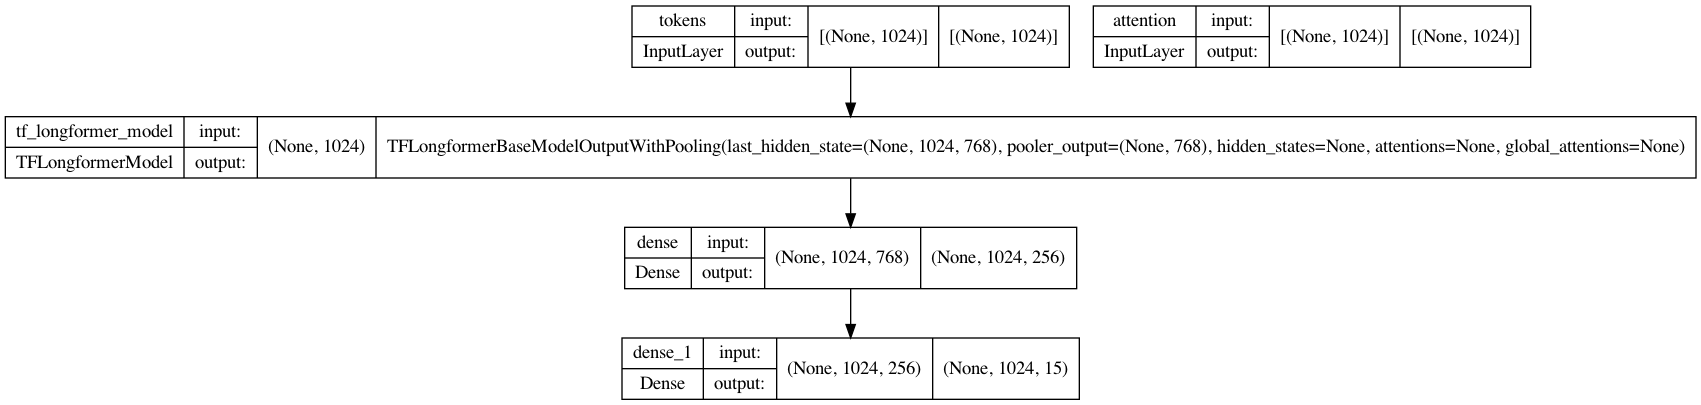

In [32]:
#! pip install pydot
#! pip install graphviz -> graphviz 설치 시 재시동, 회사에서는 좀 더 민감해서 캐치할 수 있었다 이런 실수들
plot_model(model, show_shapes=True)



##### :bulb: 급 생각 나는 **짤막 지식**
> tanh는 **HyperBolicTangent** 함수로써 relu 함수를 보완하여 함수값이 (-1,1) 인 함수이다

- 미분의 기울기의 최대값이 크게 가파르지 않다
`print(tanh)`
---------------기억의 , 지식의 절취선 -------------
- 출력 범위가 더 넓은 경사면이 더 크기 때문에 더 빠르게 학습될 수 있다
-
- 출력 값이 어쨌든 -1과 1 사이로 1보다 작은 값이기 때문에 신경망이 깊어져서 이 값들을 계속 곱하면 오차 값이 0에 가까워지는
- 기울기 소실 문제는 이도 피할 수 없기 때문에 relu함수를 사용한다
지식별 이론의 흐름의 논리 전개를 기억하고 핵심 포인트를 꼭 알아두자

> Adam optimizer
 - []
-------------
 - AdaGrad의 Momentum 개념을 활용한 것으로 가중이동평균을 적용한 개념으로 가장 최신의 기울기가 전체에 10% 정도 영향을 준다
 - Momentum 은 지수가중평균을 기초 개념으로 하는 것
 - 모멘텀 알고리즘이란, Gradient descent에서 기울기(gradient)의 가중 평균치를 산출하여 weight를 업데이트하는 것입니다. Momentum을 사용함으로써, 속도가 빠르고 SGD가 over shooting,diverging 되는 것을 방지하며 locla minimum 탈출이 가능합니다.

#### 지수 가중 평균
> vt =β{βvt−2 +(1−β)θt−1}+(1−β)θt
--------
**vt−2 앞에 0~1사이의β값이 곱해지므로 오래된 데이터일수록 현재의 경향에 미치는 영향이 줄어든다는 것을 알 수 있습니다.**
**예전 데이터는 βn으로 지수적으로 빠르게 감소하게 되기 때문에, 지수적(Exponetially) 감쇠라고 부릅니다**

In [56]:
np.random.choice(np.arange(len(IDS)), int(0.9*len(IDS)),replace=False).shape

(14034,)

In [ ]:
def build_model():

    tokens = tf.keras.layers.Input(shape=(MAX_LEN,), name = 'tokens', dtype=tf.int32)
    attention = tf.keras.layers.Input(shape=(MAX_LEN,), name = 'attention', dtype=tf.int32)

    config = AutoConfig.from_pretrained(DOWNLOADED_MODEL_PATH+'/config.json')
    backbone = TFAutoModel.from_pretrained(DOWNLOADED_MODEL_PATH+'/tf_model.h5', config=config)

    x = backbone(tokens, attention_mask=attention)
    x = tf.keras.layers.Dense(256, activation='relu')(x[0])
    x = tf.keras.layers.Dense(15, activation='softmax', dtype='float32')(x)

    model = tf.keras.Model(inputs=[tokens,attention], outputs=x)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
                  loss = [tf.keras.losses.CategoricalCrossentropy()],
                  metrics = [tf.keras.metrics.CategoricalAccuracy()])

    return model

In [ ]:
with strategy.scope():
    model = build_model()

In [41]:
# LEARNING RATE SCHEDULE AND MODEL CHECKPOINT
EPOCHS = 5
BATCH_SIZE = 4
LRS = [0.25e-4 , 0.25e-4 , 0.25e-4, 0.25e-4, 0.25e-5]
def lrfn(epoch):
    return LRS[epoch]
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn , verbose = True)

In [42]:
# TRAIN VALID SPLIT 90% 10%
np.random.seed(42)
train_idx = np.random.choice(np.arange(len(IDS)), int(0.9*len(IDS)), replace=False)
valid_idx = np.setdiff1d(np.arange(len(IDS)) , train_idx)
np.random.seed(None)
print("Train size" , len(train_idx), ', Valid size', len(valid_idx))

Train size 14034 , Valid size 1560


# :bulb:
* Validate Model - Infer OOF
    * We will now make predictions on the validation texts. Our model makes label predictions for each token, we need to convert
    * this into a list of word indices for each label . Note that the tokens and words are not the same. A single word may be broken
    * into multiple tokens. Therefore we need to first create a map to change token indices to word indices

In [ ]:
p = model. 

In [ ]:
# LOAD MODEL
if LOAD_MODEL_FROM:
    model.load_weights(f'{LOAD_MODEL_FROM}/long_v{VER}.h5')

# OR TRAIN MODEL
# 모델은 train_tokens(shape=(id,input_id)) attention shape 또한 똑같다
# targets shape는 ( IDS, MAX_LEN, class) 로 ( None, MAX_LEN, class) 이므로
# 모델의 가중치는 인풋에 대해 하나의 id안에 다양한 offset 이 있고 같은 offset이라도 다른 class로 분류되는 것을 학습한다
# 그래서 최대로 많은 class 에 할당되는 가중치를 학습한다
else:
    model.fit(x = [train_tokens[train_idx,], train_attention[train_idx,]],
          y = targets[train_idx,],
          validation_data = ([train_tokens[valid_idx,], train_attention[valid_idx,]],
                             targets[valid_idx,]),
          callbacks = [lr_callback],
          epochs = EPOCHS,
          batch_size = BATCH_SIZE,
          verbose = 2)

    # SAVE MODEL WEIGHTS
    model.save_weights(f'long_v{VER}.h5')